In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Inspect what is in station data
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [12]:
# Inspect what is in Measurement data
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
sel = [Measurement.date, Measurement.prcp]

# Find the date of the last data point
final_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
final_date = dt.datetime.strptime(final_date[0], '%Y-%m-%d').date()

# Compute the date 1yr prior to last date
initial_date = final_date + dt.timedelta(-365)

# Use initial and final dates query the last 12 months of data
precipitation_12mo = session.query(*sel).filter(Measurement.date >= initial_date).all()


In [15]:
# Create a dataframe for precipitation data
df = pd.DataFrame(precipitation_12mo,columns=['Date','Precipitation'])
df = df.sort_values(by=['Date'])

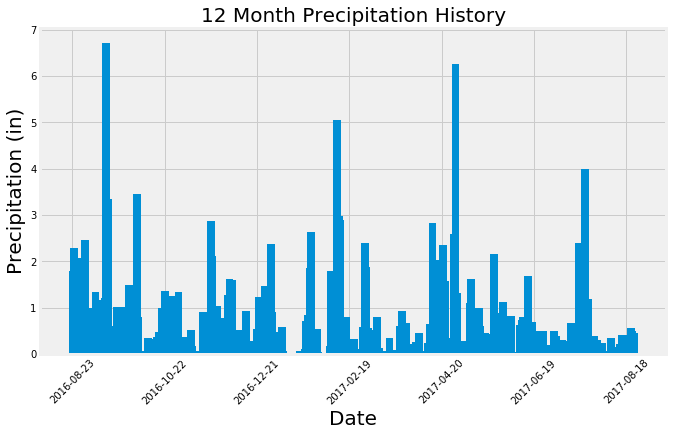

In [16]:
plt.figure(figsize=(10,6))
plt.bar(df.Date,df.Precipitation,width=5)
plt.xlabel('Date',fontsize=20)
plt.ylabel('Precipitation (in)',fontsize=20)
plt.title('12 Month Precipitation History',fontsize=20)
plt.xticks(range(0,365,60),rotation = 45)
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [18]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(func.count(session.query(Measurement.station)\
                .group_by(Measurement.station))).all()
num_stations

[(9)]

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# List stations by order of activity (most actives first)
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).\
                    desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Which station has the highest number of observations?
active_stations[0]

('USC00519281', 2772)

In [21]:
# Design a query to retrieve the last 12 months of temperature observations for the most active station.

temp_12mo = session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.date >= initial_date).\
                filter(Measurement.station == active_stations[0][0]).all()

In [22]:
temp_12mo = pd.DataFrame(temp_12mo,columns=['Date','Temp'])
temp_12mo.head()

,Date,Temp
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


In [23]:
temp_12mo.describe(include="all")

,Date,Temp
count,352,352.000000
unique,352,NaN
top,2017-04-16,NaN
freq,1,NaN
mean,NaN,73.107955
std,NaN,4.733315
min,NaN,59.000000
25%,NaN,70.000000
50%,NaN,74.000000
75%,NaN,77.000000


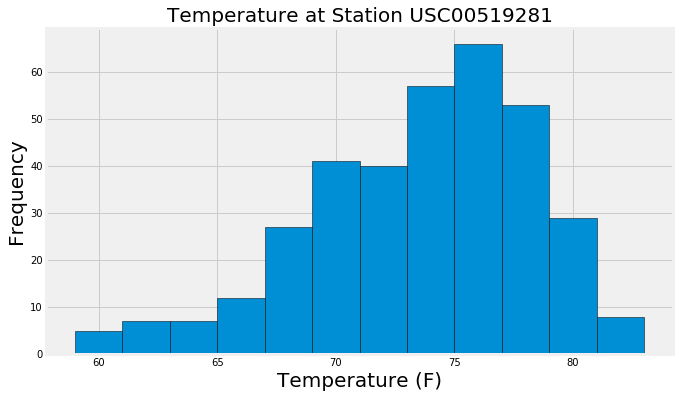

In [24]:
# Plot the results as a histogram with bins=12.

plt.figure(figsize=(10,6))
num_bins = 12
plt.hist(temp_12mo.Temp, num_bins, edgecolor='k')
plt.xlabel('Temperature (F)',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.title(f'Temperature at Station {active_stations[0][0]}',fontsize=20)
plt.show()

In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
print("Lowest Temperature:")
print(temp_12mo.min())
print("-"*12)
print("Highest Temperature:")
print(temp_12mo.max())
print("-"*12)
print("Average Temperature:")
print(temp_12mo.mean())

Lowest Temperature:
Date    2016-08-23
Temp            59
dtype: object
------------
Highest Temperature:
Date    2017-08-18
Temp            83
dtype: object
------------
Average Temperature:
Temp    73.107955
dtype: float64


In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Calculate Tmin, Tavg, Tmax for the trip date period
avg_temp = calc_temps('2017-04-25', '2017-05-05')
avg_temp

[(58.0, 73.66176470588235, 81.0)]

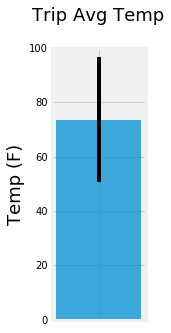

In [28]:
plt.figure(figsize=(1.5,5))
plt.bar('',avg_temp[0][1],alpha=0.75,yerr=(avg_temp[0][2]-avg_temp[0][0]))
plt.ylabel('Temp (F)',fontsize=18)
plt.ylim(0,100)
plt.title('Trip Avg Temp\n',fontsize=18)
plt.show()

# Average Daily Rainfall

In [29]:
# Function normal_rainfall takes a date and a station ID and
# returns the average rainfall based on previous years rainfall at that station

def normal_rainfall(date,i):
    
    return session.query(Measurement.station,func.avg(Measurement.prcp)).\
            filter(Measurement.station == active_stations[i][0]).\
            filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [30]:
# Input the desired day of the year for which you want rainfall
# day must be specified as a string of format "mm-dd" 
mm_dd = "04-25"

print(f'\nAverage rainfall per station on day {mm_dd} (mm-dd)\n')
print(f'[("Station ID", "Rainfall")]')
print(f'-------------------------------------------------')

# This for loop iterates over all the weather stations
# Each iteration calls normal_rainfall function and prints avg rainfall 
for i in range(len(active_stations)):
    print(normal_rainfall(mm_dd, i))

print(f'-------------------------------------------------')


Average rainfall per station on day 04-25 (mm-dd)

[("Station ID", "Rainfall")]
-------------------------------------------------
[('USC00519281', 0.155)]
[('USC00519397', 0.0025)]
[('USC00513117', 0.16125)]
[('USC00519523', 0.01)]
[('USC00516128', 0.3085714285714286)]
[('USC00514830', 0.04125)]
[('USC00511918', 0.004)]
[('USC00517948', 0.03)]
[('USC00518838', 0.005)]
-------------------------------------------------


## Optional Challenge Assignment

In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# Input start and end days in the format 'mm-dd'
start = "04-25"
end = "05-05"

print(f'\nTemperatures for period {start} to {end}\n')
print(f' Day    Tmin         Tavg          Tmax')
print(f'-------------------------------------------------')

# Change inputs to date format
start = dt.datetime.strptime(start, "%m-%d")
end = dt.datetime.strptime(end, "%m-%d")

# Create date array
date_array = (start + dt.timedelta(days=x) for x in range(0, (end-start).days))

day = []
tmin = []
tavg = []
tmax = []

# This for loop iterates over each day in the date period
# Each iteration call daily_normals function
for date_object in date_array:
    date = date_object.strftime("%m-%d")
    temps = daily_normals(date)
    day.append(date)
    tmin.append(temps[0][0]) 
    tavg.append(temps[0][1])
    tmax.append(temps[0][2])
    #print(f'{date}   {daily_normals(date)[0][0]}   {daily_normals(date)[0][1]}   {daily_normals(date)[0][2]}')
    print(f'{date}   {temps[0][0]}   {temps[0][1]}   {temps[0][2]}')

print(f'-------------------------------------------------')


Temperatures for period 04-25 to 05-05

 Day    Tmin         Tavg          Tmax
-------------------------------------------------
04-25   66.0   73.96551724137932   83.0
04-26   66.0   74.01724137931035   81.0
04-27   65.0   72.87272727272727   81.0
04-28   63.0   73.46428571428571   79.0
04-29   66.0   73.30357142857143   81.0
04-30   58.0   71.5576923076923   78.0
05-01   65.0   72.75925925925925   79.0
05-02   65.0   73.05084745762711   79.0
05-03   67.0   73.41071428571429   84.0
05-04   65.0   73.59649122807018   78.0
-------------------------------------------------


In [33]:
# Create a dataframe with daily normal temperatures for our period
temp_df = pd.DataFrame([day, tmin, tavg, tmax])
temp_df = temp_df.transpose()
temp_df.columns = ['day','tmin','tavg','tmax']
temp_df

,day,tmin,tavg,tmax
0,04-25,66,73.9655,83
1,04-26,66,74.0172,81
2,04-27,65,72.8727,81
3,04-28,63,73.4643,79
4,04-29,66,73.3036,81
5,04-30,58,71.5577,78
6,05-01,65,72.7593,79
7,05-02,65,73.0508,79
8,05-03,67,73.4107,84
9,05-04,65,73.5965,78


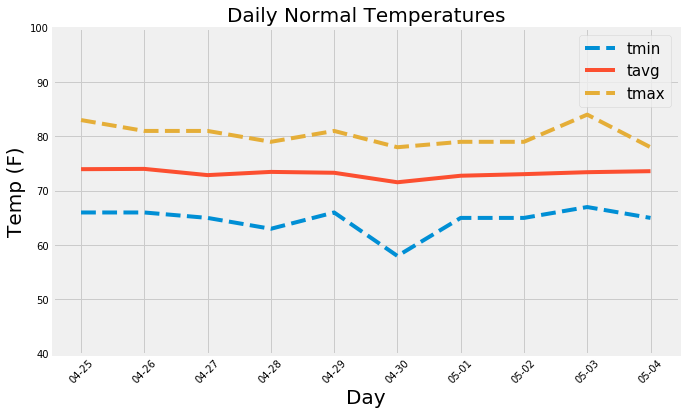

In [34]:
# Plot normal temperatures
plt.figure(figsize=(10,6))
plt.plot(temp_df.day, temp_df.tmin, linestyle='--')
plt.plot(temp_df.day, temp_df.tavg)
plt.plot(temp_df.day, temp_df.tmax, linestyle='--')
plt.ylim(40,100)
plt.xticks(rotation = 45)
plt.legend(prop={'size':15})
plt.xlabel('Day',fontsize=20)
plt.ylabel('Temp (F)',fontsize=20)
plt.title('Daily Normal Temperatures',fontsize=20)
plt.show()